In [ ]:
import random
import matplotlib.pyplot as plt
from tqdm import trange # Модуль для визуализации прогресс-бара при запуске модели
import graphviz # Модуль для визуализации графов


def mean(lst):
    return sum(lst)/len(lst)


class Model:
    def __init__(self, num_of_consumers, num_of_sellers, consumer_min, consumer_max, consumer_delta, seller_min, seller_max, seller_delta):
        '''
            Конструктор класса.

            num_of_consumers -- количество покупателей
            num_of_sellers -- количество продавцов
            consumer_min -- минимальное возможное значение max_price для покупателей
            consumer_max -- максимально возможное значение max_price для покупателей
            consumer_delta -- шаг изменения expect_price для покупателей
            seller_min -- минимальное возможное значение min_price для продавцов
            seller_max -- максимально возможное значение min_price для продавцов
            seller_delta -- шаг изменения expect_price для продавцов

        '''
        self.num_of_consumers = num_of_consumers
        self.num_of_sellers = num_of_sellers

        # Список всех продавцов модели
        self.consumers = [Consumer(consumer_min, consumer_max, consumer_delta) for _ in range(num_of_consumers)]

        # Список всех покупателей модели
        self.sellers = [Seller(seller_min, seller_max, seller_delta) for _ in range(num_of_sellers)]

        # Список списков. На позиции i находится список текущих значений expect_price для всех покупателей на шаге i.
        self.consumers_expect_price = []

        # Список списков. На позиции i находится список текущих значений expect_price для всех продавцов на шаге i.
        self.sellers_expect_price = []

        # Список результатов сделок. На позиции i находится словарь вида
        # {
        #     'consumer_id' : consumer_id,
        #     'seller_id' : seller_id
        #     'result' : result
        # }
        # где result = 1, если на i шаге была успешная сделка, иначе 0.
        self.deals_results = []


    def deal(self, consumer_id, seller_id):
        '''
            Моделирование сделки между покупателем с индексом consumer_id и продавцом с индексом seller_id

            consumer_id -- индекс покупателя в массиве self.consumers
            seller_id -- индекс продавца в массиве self.sellers
        '''

        # Сохраняем текущие значения expect_price покупателей
        self.consumers_expect_price.append([consumer.expect_price for consumer in self.consumers])

        # Сохраняем текущие значения expect_price продавцов
        self.sellers_expect_price.append([seller.expect_price for seller in self.sellers])

        if self.sellers[seller_id].expect_price <= self.consumers[consumer_id].expect_price:
            # Сделка состоялась

            # Записываем факт состоявшейся сделки
            self.deals_results.append({
                'consumer_id' : consumer_id,
                'seller_id' : seller_id,
                'result' : 1
                })

            # Данный покупатель решает уменьшить у себя expect_price
            self.consumers[consumer_id].decrease_expect_price()

            # Данный продавец решает увеличить у себя expect_price
            self.sellers[seller_id].increase_expect_price()

        else:
            # Сделка не состоялась

            # Записываем факт несостоявшейся сделки
            self.deals_results.append({
                'consumer_id' : consumer_id,
                'seller_id' : seller_id,
                'result' : 0
                })

            # Данный покупатель решает увеличить у себя expect_price
            self.sellers[seller_id].decrease_expect_price()

            # Данный продавец решает уменьшить у себя expect_price
            self.consumers[consumer_id].increase_expect_price()


    def run(self, num_of_steps):
        '''
            Запуск num_of_steps шагов модели
        '''
        for _ in trange(num_of_steps+1): # trange вместо range для визуализации прогресс-бара

            # Выбираем индекс покупателя случайным образом
            consumer_id = random.randrange(0, self.num_of_consumers)

            # Выбираем индекс продавца случайным образом
            seller_id = random.randrange(0, self.num_of_sellers)

            # Моделируем сделку
            self.deal(consumer_id, seller_id)


    def plot_dynamics(self, start, end):
        '''
            Визуализация динамики модели на шагах от start до end включительно
        '''

        # Формируем два графика по горизонтали
        fig = plt.figure(figsize = (20,5))
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)

        # Список точек по оси шагов
        steps_range = list(range(start, end+1))
        ax1.title.set_text("Динамика ожидаемых цен")

        # Среднее значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(mean, self.consumers_expect_price[start : end+1])), color='g', label = "Средняя ожидаемая цена покупателей")

        # Максимальное значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(max, self.consumers_expect_price[start : end+1])), color='g', linestyle='--', label = "Максимальная ожидаемая цена покупателей")

        # Среднее значение expect_price среди продавцов
        ax1.plot(steps_range, list(map(mean, self.sellers_expect_price[start : end+1])), color='r', label = "Средняя ожидаемая цена продавцов")

        # Минимальное значение expect_price среди продавцов
        ax1.plot(steps_range, list(map(min, self.sellers_expect_price[start : end+1])), color='r', linestyle='--', label = "Минимальная ожидаемая цена продавцов")
        ax1.legend()
        ax1.set_xlabel("Шаг")
        ax1.set_ylabel("У.Е.")


        # Находим долю успешных сделок на отрезке от start до end включительно
        deals_sum = [0]
        for i in range(start, end+1):
            deals_sum.append(deals_sum[-1] + self.deals_results[i]['result'])
        deals_fraction = [deals_sum[i] / i for i in range(1, end - start + 2)]
        ax2.title.set_text("Динамика доли сделок")
        ax2.plot(steps_range, deals_fraction, label="Доля сделок")
        ax2.legend()
        ax2.set_xlabel("Шаг")
        ax2.set_ylabel("Доля")

    def plot_supply_and_demand(self, pos_list):
        '''
            Визуализация спроса и предложения в моменты времени, указанные в списке pos_list
        '''

        # Формируем фигуру, состоящую из len(pos) графиков, расположенных горизонтально
        fig, axs = plt.subplots(1, len(pos_list), figsize = (5 * len(pos_list), 5))


        for i in range(len(pos_list)):
            # Для каждого значения из pos рисуем свой график
            axs[i].title.set_text(f"Спрос и предложение в момент {pos_list[i]}")

            # Все значения expect_price для покупателей в момент времени pos[i] сортируем по убыванию.
            # Этот график описывает функцию спроса, т.е. при заданном значении цены мы видим, какое количество покупателей готовы купить товар за данную цену или дороже
            axs[i].plot(list(range(1, self.num_of_consumers+1)), sorted(self.consumers_expect_price[pos_list[i]], reverse=True), color='g', label="Спрос")

            # Все значения expect_price для продавцов в момент времени pos[i] сортируем по возрастанию.
            # Этот график описывает функцию предложения, т.е. при заданном значении цены мы видим, какое количество продавцов готовы продать товар за данную цену или дешевле
            axs[i].plot(list(range(1, self.num_of_sellers+1)), sorted(self.sellers_expect_price[pos_list[i]]), color='r', label="Предложение")

            axs[i].legend()
            axs[i].set_xlabel("Количество")
            axs[i].set_ylabel("У.Е.")

    def plot_graph(self, start, end):
        '''
            Построение и визуализация графа удачных и неудачных сделок
            на отрезке времени от start до end.
        '''
        # Словарь для построения графа сделок.
        # Ключ -- пара (consumer_id, seller_id)
        # Значение -- словарь с ключами 'positive_count' и 'negative_count',
        # в которых будут подсчитано количество удачных и неудачных сделок
        # между consumer_id и seller_id в интервале от start до end
        g_deals = {}

        # Создание всех ключей в g_deals и инициирование нулевыми значениями
        for consumer_id in range(self.num_of_consumers):
            for seller_id in range(self.num_of_sellers):
                g_deals[(consumer_id, seller_id)] = {
                    'positive_count' : 0,
                    'negative_count' : 0,
                }

        # Для всех моментов времени от start до end
        for i in range(start, end+1):


            if self.deals_results[i]['result'] == 0: #Если сделка неудачная
                # то увеличиваем счетчик неудачных сделок для данной пары consumer_id и seller_id
                g_deals[self.deals_results[i]['consumer_id'], self.deals_results[i]['seller_id']]['negative_count'] += 1
            else:
                g_deals[self.deals_results[i]['consumer_id'], self.deals_results[i]['seller_id']]['positive_count'] += 1

        max_value = 0
        for edge, value in g_deals.items():
            max_value = max(max_value, value['negative_count'], value['positive_count'])

        graph = graphviz.Graph()
        for consumer_id in range(self.num_of_consumers):
            graph.node(f"С {consumer_id}", label=str(consumer_id), style='filled', fillcolor='blue')

        for seller_id in range(self.num_of_sellers):
            graph.node(f"S {seller_id}", label=str(seller_id), style='filled', fillcolor='magenta', shape='box')

        def get_penwidth(x):
            return str(10*x // max_value)

        for edge, value in g_deals.items():
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth = get_penwidth(value['negative_count']), color="red")
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth =  get_penwidth(value['positive_count']), color="green")

        graph.attr(layout="circo")
        return graph


class Consumer:
    def __init__(self, consumer_min, consumer_max, consumer_delta):
        self.max_price = consumer_min + random.random()*(consumer_max - consumer_min)
        self.expect_price = 0
        self.delta = consumer_delta

    def increase_expect_price(self):
        if self.expect_price + self.delta <= self.max_price:
            self.expect_price += self.delta

    def decrease_expect_price(self):
        self.expect_price -= self.delta


class Seller:
    def __init__(self, seller_min, seller_max, seller_delta):
        self.min_price = seller_min + random.random()*(seller_max - seller_min)
        self.expect_price = seller_max
        self.delta = seller_delta

    def increase_expect_price(self):
        self.expect_price += self.delta

    def decrease_expect_price(self):
        if self.expect_price - self.delta >= self.min_price:
            self.expect_price -= self.delta



In [ ]:
random.seed(42)
model = Model(num_of_consumers=3,
              num_of_sellers=3,
              consumer_min=10,
              consumer_max=11,
              consumer_delta=1,
              seller_min=5,
              seller_max=6,
              seller_delta=1)
model.run(1000)

100%|██████████| 1001/1001 [00:00<00:00, 118621.75it/s]


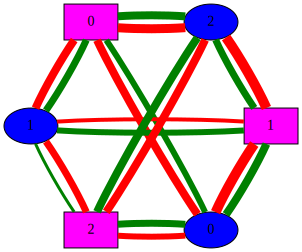

In [ ]:
model.plot_graph(0, 300)

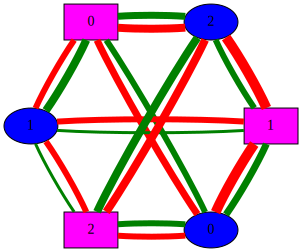

In [ ]:
model.plot_graph(0, 300)


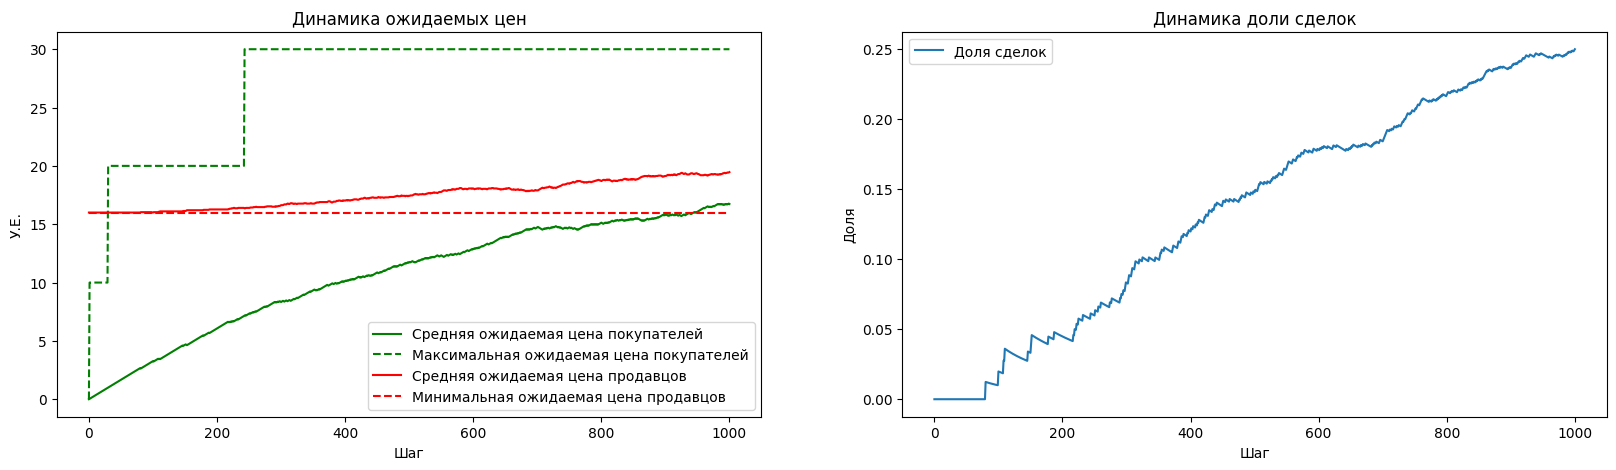

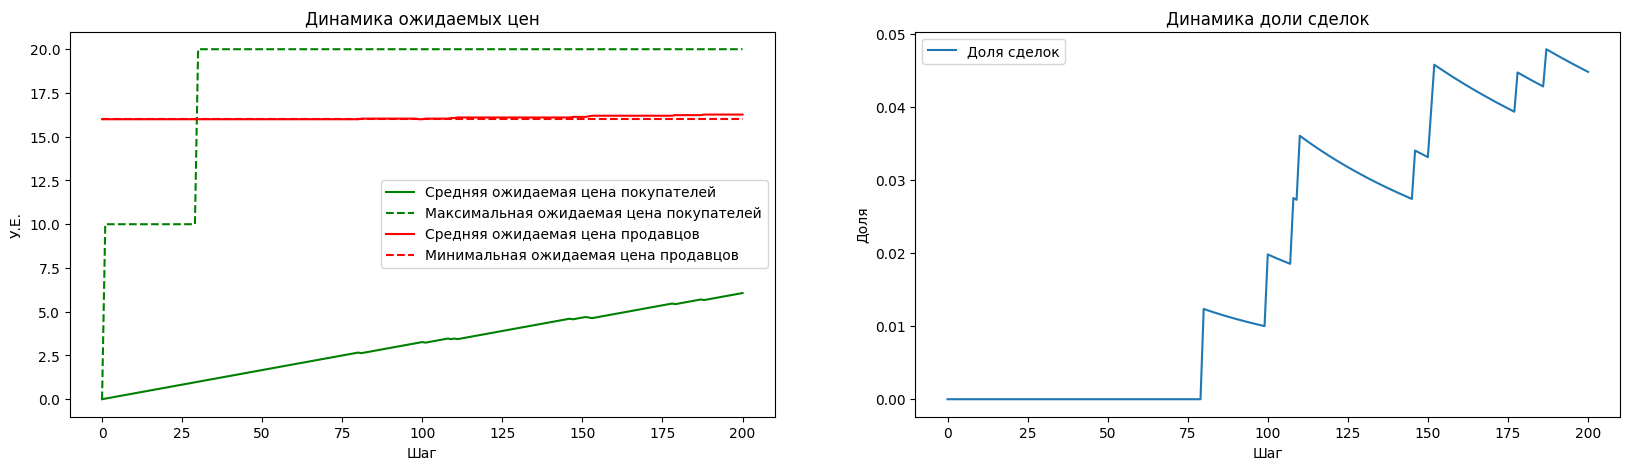

In [ ]:
model.plot_dynamics(0, 1000)
model.plot_dynamics(0, 200)

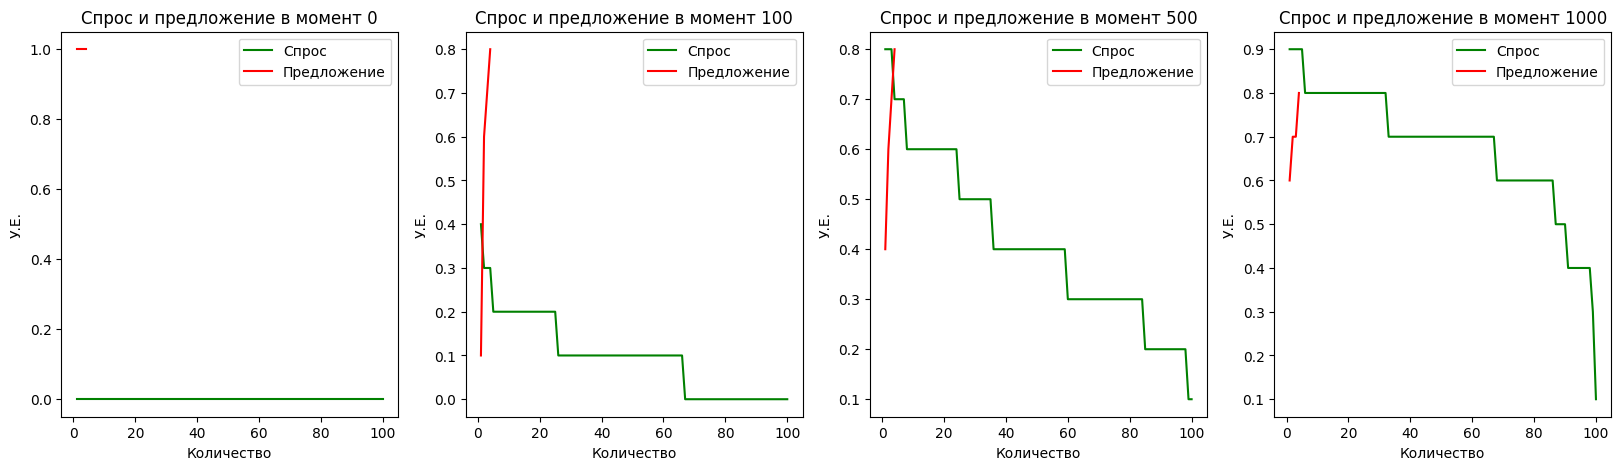

In [ ]:
model.plot_supply_and_demand([0, 100, 500, 1000])

In [ ]:
import random
import matplotlib.pyplot as plt
from tqdm import trange  # Модуль для визуализации прогресс-бара при запуске модели
import graphviz  # Модуль для визуализации графов


def mean(lst):
    return sum(lst) / len(lst)


class Model_Modef1:
    def __init__(self, num_of_consumers, num_of_sellers, consumer_min, consumer_max, consumer_delta, seller_min,
                 seller_max, seller_delta):
        '''
            Конструктор класса.

            num_of_consumers -- количество покупателей
            num_of_sellers -- количество продавцов
            consumer_min -- минимальное возможное значение max_price для покупателей
            consumer_max -- максимально возможное значение max_price для покупателей
            consumer_delta -- шаг изменения expect_price для покупателей
            seller_min -- минимальное возможное значение min_price для продавцов
            seller_max -- максимально возможное значение min_price для продавцов
            seller_delta -- шаг изменения expect_price для продавцов

        '''
        self.num_of_consumers = num_of_consumers
        self.num_of_sellers = num_of_sellers

        # Будет происходить деление продавцов и покупателей на 3 группы

        # В первой группе покупателей будут минимальные max_price (то есть хотят заплатить как можно меньше), в третьей группе - максимальные get_cons_minp (то есть готовы заплатить
        # больше всех остальных в данный момент), во второй - все оставшиеся

        # В первой группе продавцов будут минимальные min_price (то есть готовы продавать по меньшей цене, чем другие в данный момент), в третьей группе - максимальные min_price
        # (то есть хотят продать как можно дороже), во второй - все оставшиеся

        # Сначала создадим общие массивы consumers и sellers со всеми покупателями и продавцами, затем отсортируем их по max_price и min_price соответственно

        consumers = [Consumer(consumer_min, consumer_max, consumer_delta) for _ in range(0, num_of_consumers)]
        sellers = [Seller(seller_min, seller_max, seller_delta) for _ in range(0, num_of_sellers)]

        def get_cons_maxp(consumer):
            return consumer.max_price

        consumers_sorted = sorted(consumers, key=get_cons_maxp)

        def get_sell_minp(seller):
            return seller.min_price

        sellers_sorted = sorted(sellers, key=get_sell_minp)

        # Теперь создадим по 3 группы для покупателей и продавцов и распределим их

        # Список всех групп продавцов модели
        self.consumers1 = []
        self.consumers2 = []
        self.consumers3 = []

        for i in range(num_of_consumers // 3):
            self.consumers1.append(consumers_sorted[i])
        for i in range(num_of_consumers // 3, 2 * num_of_consumers // 3):
            self.consumers2.append(consumers_sorted[i])
        for i in range(2 * num_of_consumers // 3, num_of_consumers):
            self.consumers3.append(consumers_sorted[i])

        # Список всех групп покупателей модели
        self.sellers1 = []
        self.sellers2 = []
        self.sellers3 = []

        for i in range(num_of_sellers // 3):
            self.sellers1.append(sellers_sorted[i])
        for i in range(num_of_sellers // 3, 2 * num_of_sellers // 3):
            self.sellers2.append(sellers_sorted[i])
        for i in range(2 * num_of_sellers // 3, num_of_sellers):
            self.sellers3.append(sellers_sorted[i])

        # Списки списков. На позиции i для каждой группы находится список текущих значений expect_price для всех покупателей данной группы на шаге i.
        self.consumers_expect_price1 = []
        self.consumers_expect_price2 = []
        self.consumers_expect_price3 = []

        # Списки списков. На позиции i для каждой группы находится список текущих значений expect_price для всех продавцов данной группы на шаге i.
        self.sellers_expect_price1 = []
        self.sellers_expect_price2 = []
        self.sellers_expect_price3 = []

        # Список результатов сделок для каждой группы. На позиции i находится словарь вида
        # {
        #     'consumer_id' : consumer_id,
        #     'consumer_group' : consumer_group,
        #     'seller_id' : seller_id
        #     'seller_group' : seller_group,
        #     'result' : result
        # }
        # где result = 1, если на i шаге была успешная сделка, иначе 0.
        self.deals_results = []

    def deal(self, consumer_id, seller_id, group_consumer, group_seller):
        '''
            Моделирование сделки между покупателем с индексом consumer_id и продавцом с индексом seller_id

            consumer_id -- индекс покупателя в массиве self.consumers
            seller_id -- индекс продавца в массиве self.sellers
            group_consumer - группа покупателя (1,2,3)
            group_seller - группа продавца (1,2,3)
        '''

        # Сохраняем текущие значения expect_price покупателей в зависимости от группы, к которой принадлежит покупатель с consumer_id
        mass_consumers = [0]

        if group_consumer == 1:
            self.consumers_expect_price1.append([consumer.expect_price for consumer in self.consumers1])
            mass_consumers = self.consumers1
        elif group_consumer == 2:
            self.consumers_expect_price2.append([consumer.expect_price for consumer in self.consumers2])
            mass_consumers = self.consumers2
        else:
            self.consumers_expect_price3.append([consumer.expect_price for consumer in self.consumers3])
            mass_consumers = self.consumers3

        # Сохраняем текущие значения expect_price продавцов в зависимости от группы, к которой принадлежит продавец с seller_id
        mass_sellers = [0]
        if group_seller == 1:
            self.sellers_expect_price1.append([seller.expect_price for seller in self.sellers1])
            mass_sellers = self.sellers1
        if group_seller == 2:
            self.sellers_expect_price2.append([seller.expect_price for seller in self.sellers2])
            mass_sellers = self.sellers2
        else:
            self.sellers_expect_price3.append([seller.expect_price for seller in self.sellers3])
            mass_sellers = self.sellers3

        if mass_sellers[seller_id].expect_price <= mass_consumers[consumer_id].expect_price:
            # Сделка состоялась

            # Записываем факт состоявшейся сделки
            self.deals_results.append({
                'consumer_id': consumer_id,
                'consumer_group': group_consumer,
                'seller_id': seller_id,
                'seller_group': group_seller,
                'result': 1
            })
            # Данный покупатель решает уменьшить у себя expect_price в рамках своей группы
            if group_consumer == 1:
                self.consumers1[consumer_id].decrease_expect_price()
            elif group_consumer == 2:
                self.consumers2[consumer_id].decrease_expect_price()
            else:
                self.consumers3[consumer_id].decrease_expect_price()

            # Данный продавец решает увеличить у себя expect_price в рамках своей группы
            if group_seller == 1:
                self.sellers1[seller_id].increase_expect_price()
            elif group_seller == 2:
                self.sellers2[seller_id].increase_expect_price()
            else:
                self.sellers3[seller_id].increase_expect_price()

        else:
            # Сделка не состоялась

            # Записываем факт несостоявшейся сделки
            self.deals_results.append({
                'consumer_id': consumer_id,
                'consumer_group': group_consumer,
                'seller_id': seller_id,
                'seller_group': group_seller,
                'result': 0
            })

            # Данный  продавец решает уменьшить у себя expect_price в рамках своей группы

            if group_seller == 1:
                self.sellers1[seller_id].decrease_expect_price()
            elif group_seller == 2:
                self.sellers2[seller_id].decrease_expect_price()
            else:
                self.sellers3[seller_id].decrease_expect_price()

            # Данный покупатель решает увеличить у себя expect_price в рамках своей группы
            if group_consumer == 1:
                self.consumers1[consumer_id].increase_expect_price()
            elif group_consumer == 2:
                self.consumers2[consumer_id].increase_expect_price()
            else:
                self.consumers3[consumer_id].increase_expect_price()

    def run(self, num_of_steps):
        '''
            Запуск num_of_steps шагов модели
        '''
        for _ in trange(num_of_steps + 1):  # trange вместо range для визуализации прогресс-бара
            # Необходимо за шаг запустить сделку для каждой группы продавцов и каждой группы покупателей

            # Выбираем индекс покупателя случайным образом
            consumer_id = random.randrange(0, self.num_of_consumers // 3)

            # Выбираем индекс продавца случайным образом
            seller_id = random.randrange(0, self.num_of_sellers // 3)

            # Выбираем индекс группы покупателя случайным образом
            consumer_group1 = random.randrange(1, 4)

            # Выбираем индекс группы покупателя случайным образом
            seller_group1 = random.randrange(1, 4)

            consumer_group2 = random.randrange(1, 4)
            while consumer_group2 == consumer_group1:
                consumer_group2 = random.randrange(1, 4)

            seller_group2 = random.randrange(1, 4)
            while seller_group2 == seller_group1:
                seller_group2 = random.randrange(1, 4)

            consumer_group3 = 1 + 2 + 3 - consumer_group1 - consumer_group2
            seller_group3 = 1 + 2 + 3 - seller_group1 - seller_group2

            # Моделируем сделки
            self.deal(consumer_id, seller_id, consumer_group1, seller_group1)
            self.deal(consumer_id, seller_id, consumer_group2, seller_group2)
            self.deal(consumer_id, seller_id, consumer_group3, seller_group3)

    def plot_dynamics(self, start, end):
        '''
            Визуализация динамики модели на шагах от start до end включительно
        '''

        # Формируем два графика по горизонтали
        fig1 = plt.figure(figsize=(20, 5))
        fig2 = plt.figure(figsize=(20, 5))
        fig3 = plt.figure(figsize=(20, 5))
        fig4 = plt.figure(figsize=(20, 5))
        ax1 = fig1.add_subplot(1, 2,
                               1)  # здесь будет фиксироваться первая группа продавцов и будут все группы покупателей
        ax2 = fig2.add_subplot(1, 2,
                               1)  # здесь будет фиксироваться вторая группа продавцов и будут все группы покупателей
        ax3 = fig3.add_subplot(1, 2,
                               1)  # здесь будет фиксироваться третья группа продавцов и будут все группы покупателей
        ax4 = fig4.add_subplot(1, 2, 2)  # график долей

        # Список точек по оси шагов
        steps_range = list(range(start, end + 1))
        ax1.title.set_text("Динамика ожидаемых цен")
        ax2.title.set_text("Динамика ожидаемых цен")
        ax3.title.set_text("Динамика ожидаемых цен")

        # Среднее значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(mean, self.consumers_expect_price1[start: end + 1])), color='g',
                 label="Средняя ожидаемая цена покупателей из группы 1")
        ax1.plot(steps_range, list(map(mean, self.consumers_expect_price2[start: end + 1])), color='b',
                 label="Средняя ожидаемая цена покупателей из группы 2")
        ax1.plot(steps_range, list(map(mean, self.consumers_expect_price3[start: end + 1])), color='m',
                 label="Средняя ожидаемая цена покупателей из группы 3")

        ax2.plot(steps_range, list(map(mean, self.consumers_expect_price1[start: end + 1])), color='g',
                 label="Средняя ожидаемая цена покупателей из группы 1")
        ax2.plot(steps_range, list(map(mean, self.consumers_expect_price2[start: end + 1])), color='b',
                 label="Средняя ожидаемая цена покупателей из группы 2")
        ax2.plot(steps_range, list(map(mean, self.consumers_expect_price3[start: end + 1])), color='m',
                 label="Средняя ожидаемая цена покупателей из группы 3")

        ax3.plot(steps_range, list(map(mean, self.consumers_expect_price1[start: end + 1])), color='g',
                 label="Средняя ожидаемая цена покупателей из группы 1")
        ax3.plot(steps_range, list(map(mean, self.consumers_expect_price2[start: end + 1])), color='b',
                 label="Средняя ожидаемая цена покупателей из группы 2")
        ax3.plot(steps_range, list(map(mean, self.consumers_expect_price3[start: end + 1])), color='m',
                 label="Средняя ожидаемая цена покупателей из группы 3")

        # Максимальное значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(max, self.consumers_expect_price1[start: end + 1])), color='g', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 1")
        ax1.plot(steps_range, list(map(max, self.consumers_expect_price2[start: end + 1])), color='b', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 2")
        ax1.plot(steps_range, list(map(max, self.consumers_expect_price3[start: end + 1])), color='m', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 3")

        ax2.plot(steps_range, list(map(max, self.consumers_expect_price1[start: end + 1])), color='g', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 1")
        ax2.plot(steps_range, list(map(max, self.consumers_expect_price2[start: end + 1])), color='b', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 2")
        ax2.plot(steps_range, list(map(max, self.consumers_expect_price3[start: end + 1])), color='m', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 3")

        ax3.plot(steps_range, list(map(max, self.consumers_expect_price1[start: end + 1])), color='g', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 1")
        ax3.plot(steps_range, list(map(max, self.consumers_expect_price2[start: end + 1])), color='b', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 2")
        ax3.plot(steps_range, list(map(max, self.consumers_expect_price3[start: end + 1])), color='m', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей из группы 3")

        # Среднее значение expect_price среди продавцов (на каждом графике одна группа продавцов)
        ax1.plot(steps_range, list(map(mean, self.sellers_expect_price1[start: end + 1])), color='r',
                 label="Средняя ожидаемая цена продавцов из группы 1")
        ax2.plot(steps_range, list(map(mean, self.sellers_expect_price2[start: end + 1])), color='r',
                 label="Средняя ожидаемая цена продавцов из группы 2")
        ax3.plot(steps_range, list(map(mean, self.sellers_expect_price3[start: end + 1])), color='r',
                 label="Средняя ожидаемая цена продавцов из группы 3")

        # Минимальное значение expect_price среди продавцов (на каждом графике одна группа продавцов)
        ax1.plot(steps_range, list(map(min, self.sellers_expect_price1[start: end + 1])), color='r', linestyle='--',
                 label="Минимальная ожидаемая цена продавцов из группы 1")
        ax2.plot(steps_range, list(map(min, self.sellers_expect_price2[start: end + 1])), color='r', linestyle='--',
                 label="Минимальная ожидаемая цена продавцов из группы 2")
        ax3.plot(steps_range, list(map(min, self.sellers_expect_price3[start: end + 1])), color='r', linestyle='--',
                 label="Минимальная ожидаемая цена продавцов из группы 3")

        ax1.legend()
        ax1.set_xlabel("Шаг")
        ax1.set_ylabel("У.Е.")

        ax2.legend()
        ax2.set_xlabel("Шаг")
        ax2.set_ylabel("У.Е.")

        ax3.legend()
        ax3.set_xlabel("Шаг")
        ax3.set_ylabel("У.Е.")

        # Находим долю успешных сделок на отрезке от start до end включительно для каждой пары, состоящей из одной группы продавцов и одной группы покупателей, то есть всего будет 9 линий,
        deals_sum1 = [0]  # 1 группа продавцов и 1 группа покупателей
        deals_sum2 = [0]  # 1 группа продавцов и 2 группа покупателей
        deals_sum3 = [0]  # 1 группа продавцов и 3 группа покупателей
        deals_sum4 = [0]  # 2 группа продавцов и 1 группа покупателей
        deals_sum5 = [0]  # 2 группа продавцов и 2 группа покупателей
        deals_sum6 = [0]  # 2 группа продавцов и 3 группа покупателей
        deals_sum7 = [0]  # 3 группа продавцов и 1 группа покупателей
        deals_sum8 = [0]  # 3 группа продавцов и 2 группа покупателей
        deals_sum9 = [0]  # 3 группа продавцов и 3 группа покупателей

        deals_sum = [0]

        steps_range1 = []
        steps_range2 = []
        steps_range3 = []
        steps_range4 = []
        steps_range5 = []
        steps_range6 = []
        steps_range7 = []
        steps_range8 = []
        steps_range9 = []

        for i in range(start, end + 1):
            if self.deals_results[i]['seller_group'] == 1 and self.deals_results[i]['consumer_group'] == 1:
                deals_sum.append(
                    [deals_sum1[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum1.append(deals_sum1[-1] + self.deals_results[i]['result'])
                steps_range1.append(i)
            if self.deals_results[i]['seller_group'] == 1 and self.deals_results[i]['consumer_group'] == 2:
                deals_sum.append(
                    [deals_sum2[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum2.append(deals_sum2[-1] + self.deals_results[i]['result'])
                steps_range2.append(i)
            if self.deals_results[i]['seller_group'] == 1 and self.deals_results[i]['consumer_group'] == 3:
                deals_sum.append(
                    [deals_sum3[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum3.append(deals_sum3[-1] + self.deals_results[i]['result'])
                steps_range3.append(i)
            if self.deals_results[i]['seller_group'] == 2 and self.deals_results[i]['consumer_group'] == 1:
                deals_sum.append(
                    [deals_sum4[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum4.append(deals_sum4[-1] + self.deals_results[i]['result'])
                steps_range4.append(i)
            if self.deals_results[i]['seller_group'] == 2 and self.deals_results[i]['consumer_group'] == 2:
                deals_sum.append(
                    [deals_sum5[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum5.append(deals_sum5[-1] + self.deals_results[i]['result'])
                steps_range5.append(i)
            if self.deals_results[i]['seller_group'] == 2 and self.deals_results[i]['consumer_group'] == 3:
                deals_sum.append(
                    [deals_sum6[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum6.append(deals_sum6[-1] + self.deals_results[i]['result'])
                steps_range6.append(i)
            if self.deals_results[i]['seller_group'] == 3 and self.deals_results[i]['consumer_group'] == 1:
                deals_sum.append(
                    [deals_sum7[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum7.append(deals_sum7[-1] + self.deals_results[i]['result'])
                steps_range7.append(i)
            if self.deals_results[i]['seller_group'] == 3 and self.deals_results[i]['consumer_group'] == 2:
                deals_sum.append(
                    [deals_sum8[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum8.append(deals_sum8[-1] + self.deals_results[i]['result'])
                steps_range8.append(i)
            if self.deals_results[i]['seller_group'] == 3 and self.deals_results[i]['consumer_group'] == 3:
                deals_sum.append(
                    [deals_sum9[-1] + self.deals_results[i]['result'], self.deals_results[i]['seller_group'],
                     self.deals_results[i]['consumer_group']])
                deals_sum9.append(deals_sum9[-1] + self.deals_results[i]['result'])
                steps_range9.append(i)

        deals_fraction1 = [deals_sum1[i] / i for i in range(1, len(deals_sum1))]
        deals_fraction2 = [deals_sum2[i] / i for i in range(1, len(deals_sum2))]
        deals_fraction3 = [deals_sum3[i] / i for i in range(1, len(deals_sum3))]
        deals_fraction4 = [deals_sum4[i] / i for i in range(1, len(deals_sum4))]
        deals_fraction5 = [deals_sum5[i] / i for i in range(1, len(deals_sum5))]
        deals_fraction6 = [deals_sum6[i] / i for i in range(1, len(deals_sum6))]
        deals_fraction7 = [deals_sum7[i] / i for i in range(1, len(deals_sum7))]
        deals_fraction8 = [deals_sum8[i] / i for i in range(1, len(deals_sum8))]
        deals_fraction9 = [deals_sum9[i] / i for i in range(1, len(deals_sum9))]

        ax4.title.set_text("Динамика доли сделок")
        ax4.plot(steps_range1, deals_fraction1, color='blue',
                 label="Доля сделок между 1 группой продавцов и 1 группой покупателей")
        ax4.plot(steps_range2, deals_fraction2, color='dodgerblue',
                 label="Доля сделок между 1 группой продавцов и 2 группой покупателей")
        ax4.plot(steps_range3, deals_fraction3, color='skyblue',
                 label="Доля сделок между 1 группой продавцов и 3 группой покупателей")
        ax4.plot(steps_range4, deals_fraction4, color='red',
                 label="Доля сделок между 2 группой продавцов и 1 группой покупателей")
        ax4.plot(steps_range5, deals_fraction5, color='coral',
                 label="Доля сделок между 2 группой продавцов и 2 группой покупателей")
        ax4.plot(steps_range6, deals_fraction6, color='gold',
                 label="Доля сделок между 2 группой продавцов и 3 группой покупателей")
        ax4.plot(steps_range7, deals_fraction7, color='limegreen',
                 label="Доля сделок между 3 группой продавцов и 1 группой покупателей")
        ax4.plot(steps_range8, deals_fraction8, color='lime',
                 label="Доля сделок между 3 группой продавцов и 2 группой покупателей")
        ax4.plot(steps_range9, deals_fraction9, color='greenyellow',
                 label="Доля сделок между 3 группой продавцов и 3 группой покупателей")
        ax4.legend()
        ax4.set_xlabel("Шаг")
        ax4.set_ylabel("Доля")

    def plot_supply_and_demand(self, pos_list):
        '''
            Визуализация спроса и предложения в моменты времени, указанные в списке pos_list
        '''
        # Формируем фигуру, состоящую из len(pos) графиков, расположенных горизонтально
        fig, axs = plt.subplots(1, len(pos_list), figsize=(5 * len(pos_list), 5))

        # Создадим массив, в котором будет храниться средняя ожидаемая цена по 3 группам покупателей
        consumers_expect_price = [[0]*self.num_of_consumers]
        for i in range(max(pos_list)):
            middle = [0]
            for j in self.consumers_expect_price1[i]:
                middle.append(j)
            for j in self.consumers_expect_price2[i]:
                middle.append(j)
            for j in self.consumers_expect_price3[i]:
                middle.append(j)
            consumers_expect_price.append(middle)

        # Создадим массив, в котором будет храниться средняя ожидаемая цена по 3 группам продавцов
        sellers_expect_price = [[0]*self.num_of_sellers]
        for i in range(max(pos_list)):
            middle = [0]
            for j in self.sellers_expect_price1[i]:
                middle.append(j)
            for j in self.sellers_expect_price2[i]:
                middle.append(j)
            for j in self.sellers_expect_price3[i]:
                middle.append(j)
            sellers_expect_price.append(middle)

        for i in range(len(pos_list)):
            # Для каждого значения из pos рисуем свой график
            axs[i].title.set_text(f"Спрос и предложение в момент {pos_list[i]}")

            # Все значения expect_price для покупателей в момент времени pos[i] сортируем по убыванию.
            # Этот график описывает функцию спроса, т.е. при заданном значении цены мы видим, какое количество покупателей готовы купить товар за данную цену или дороже
            axs[i].plot(list(range(1, self.num_of_consumers + 1)),
                        sorted(consumers_expect_price[pos_list[i]][:self.num_of_consumers], reverse=True), color='g', label="Спрос")

            # Все значения expect_price для продавцов в момент времени pos[i] сортируем по возрастанию.
            # Этот график описывает функцию предложения, т.е. при заданном значении цены мы видим, какое количество продавцов готовы продать товар за данную цену или дешевле
            axs[i].plot(list(range(1, self.num_of_sellers + 1)), sorted(sellers_expect_price[pos_list[i]])[:self.num_of_sellers], color='r',
                        label="Предложение")

            axs[i].legend()
            axs[i].set_xlabel("Количество")
            axs[i].set_ylabel("У.Е.")

    def plot_graph(self, start, end):
        '''
            Построение и визуализация графа удачных и неудачных сделок
            на отрезке времени от start до end.
        '''

        # Словарь для построения графа сделок.
        # Ключ -- пара (consumer_id, seller_id)
        # Значение -- словарь с ключами 'positive_count' и 'negative_count',
        # в которых будут подсчитано количество удачных и неудачных сделок
        # между consumer_id и seller_id в интервале от start до end
        g_deals = {}

        # Создание всех ключей в g_deals и инициирование нулевыми значениями
        for consumer_id in range(self.num_of_consumers):
            for seller_id in range(self.num_of_sellers):
                g_deals[(consumer_id, seller_id)] = {
                    'positive_count': 0,
                    'negative_count': 0,
                }

        # Присвоим каждому покупателю и продавцу id не по группе, а общий по всему количеству. Первая треть людей на
        id_cons = {}
        last1 = 0
        for i in range(1, 4):
            for j in range(self.num_of_consumers//3):
                id_cons[i, j] = last1
                last1 += 1

        id_sell = {}
        last2 = 0
        for i in range(1, 4):
            for j in range(self.num_of_sellers//3):
                id_sell[i, j] = last2
                last2 += 1

        # Для всех моментов времени от start до end. Необходимо домножить на 3, так как на каждом шаге мы создавали по 3 сделки, чтобы
        # участвовала каждая группа продавцов и покупателей
        for i in range(start, (end + 1)*3):
            if self.deals_results[i]['result'] == 0:  # Если сделка неудачная
                # то увеличиваем счетчик неудачных сделок для данной пары consumer_id и seller_id
                g_deals[id_cons[self.deals_results[i]['consumer_group'],self.deals_results[i]['consumer_id']], id_sell[self.deals_results[i]['seller_group'],self.deals_results[i]['seller_id']]]['negative_count'] += 1
            else:
                g_deals[id_cons[self.deals_results[i]['consumer_group'],self.deals_results[i]['consumer_id']], id_sell[self.deals_results[i]['seller_group'],self.deals_results[i]['seller_id']]]['positive_count'] += 1

        max_value = 0
        for edge, value in g_deals.items():
            max_value = max(max_value, value['negative_count'], value['positive_count'])

        graph = graphviz.Graph()
        for consumer_id in range(self.num_of_consumers):
            graph.node(f"С {consumer_id}", label=str(consumer_id), style='filled', fillcolor='blue')

        for seller_id in range(self.num_of_sellers):
            graph.node(f"S {seller_id}", label=str(seller_id), style='filled', fillcolor='magenta', shape='box')

        def get_penwidth(x):
            return str(10 * x // max_value)

        for edge, value in g_deals.items():
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth=get_penwidth(value['negative_count']), color="red")
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth=get_penwidth(value['positive_count']), color="green")

        graph.attr(layout="circo")
        return graph


class Consumer:
    def __init__(self, consumer_min, consumer_max, consumer_delta):
        self.max_price = consumer_min + random.random() * (consumer_max - consumer_min)
        self.expect_price = 0
        self.delta = consumer_delta

    def increase_expect_price(self):
        if self.expect_price + self.delta <= self.max_price:
            self.expect_price += self.delta

    def decrease_expect_price(self):
        self.expect_price -= self.delta


class Seller:
    def __init__(self, seller_min, seller_max, seller_delta):
        self.min_price = seller_min + random.random() * (seller_max - seller_min)
        self.expect_price = seller_max
        self.delta = seller_delta

    def increase_expect_price(self):
        self.expect_price += self.delta

    def decrease_expect_price(self):
        if self.expect_price - self.delta >= self.min_price:
            self.expect_price -= self.delta

In [ ]:
random.seed(42)
model = Model_Modef1(num_of_consumers=5,
              num_of_sellers=5,
              consumer_min=15,
              consumer_max=20,
              consumer_delta=0.3,
              seller_min=10,
              seller_max=13,
              seller_delta=0.3)
model.run(1000)

100%|██████████| 1001/1001 [00:00<00:00, 40993.75it/s]


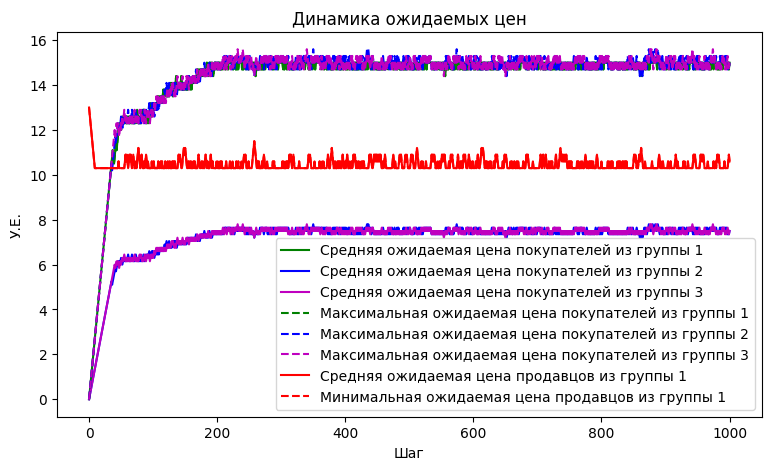

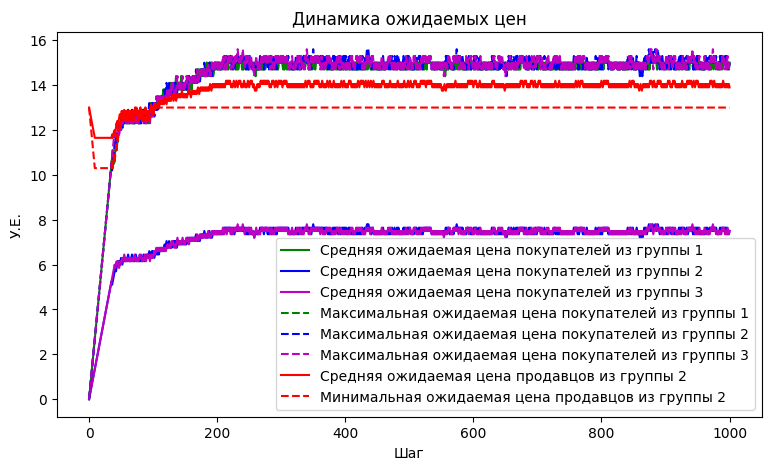

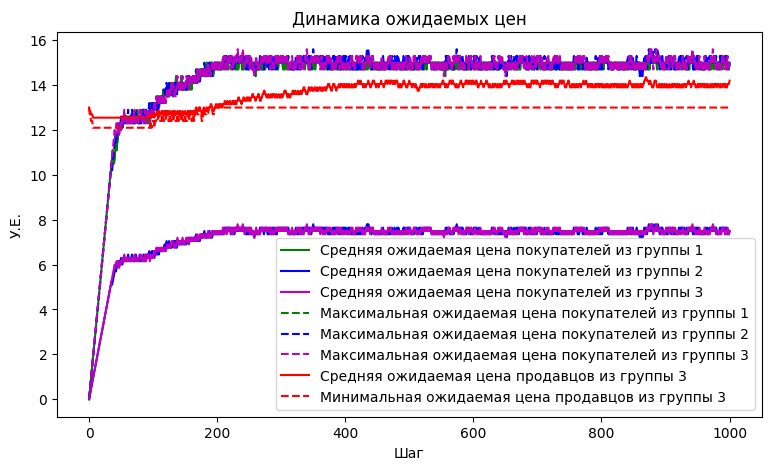

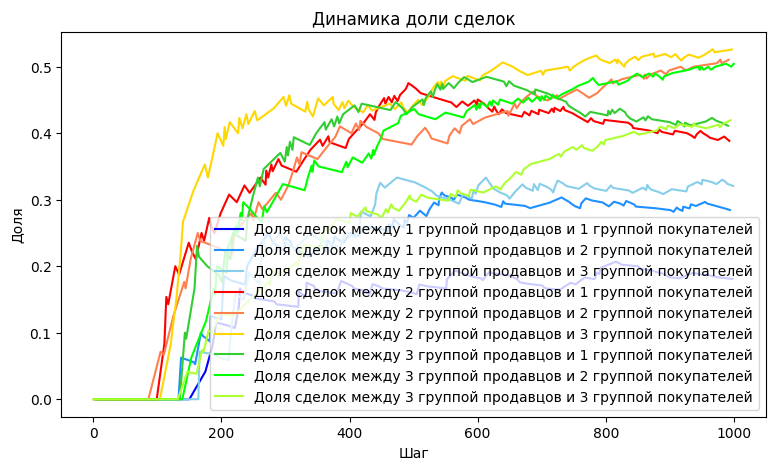

In [ ]:
model.plot_dynamics(0, 1000)

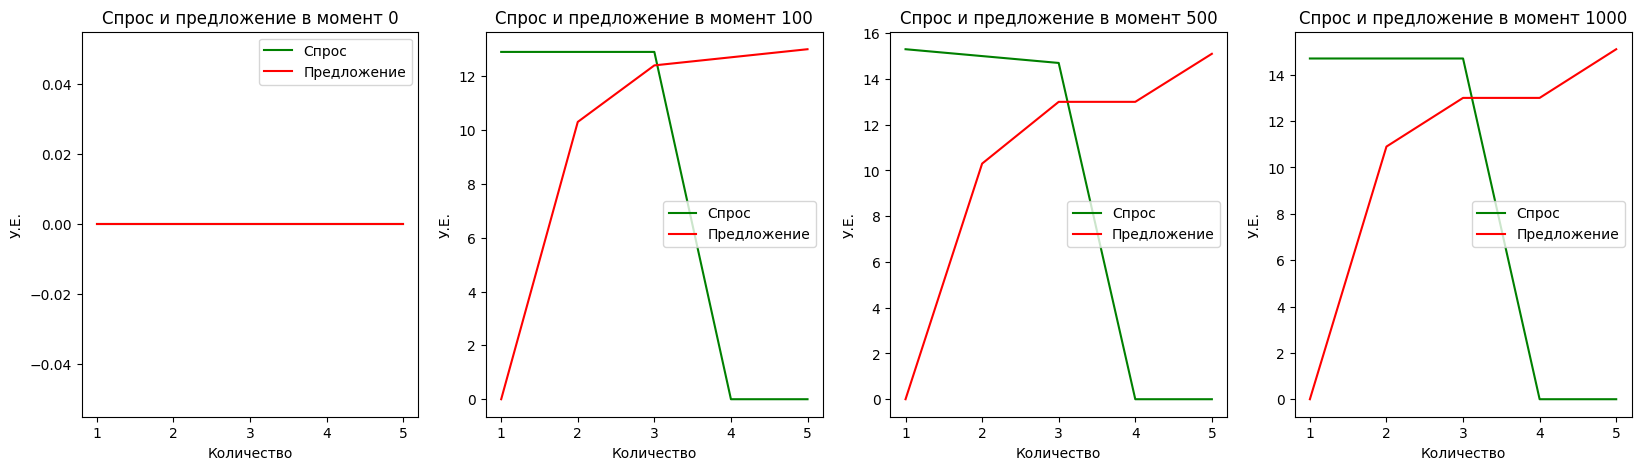

In [ ]:
model.plot_supply_and_demand([0, 100, 500, 1000])

In [ ]:
import random
import matplotlib.pyplot as plt
from tqdm import trange  # Модуль для визуализации прогресс-бара при запуске модели
import graphviz  # Модуль для визуализации графов
from random import randint


def mean(lst):
    return sum(lst) / len(lst)


class Model_Modef2:
    def __init__(self, num_of_consumers, num_of_sellers, consumer_min, consumer_max, consumer_delta, seller_min,
                 seller_max, seller_delta, max_connections):
        '''
            Конструктор класса.

            num_of_consumers -- количество покупателей
            num_of_sellers -- количество продавцов
            consumer_min -- минимальное возможное значение max_price для покупателей
            consumer_max -- максимально возможное значение max_price для покупателей
            consumer_delta -- шаг изменения expect_price для покупателей
            seller_min -- минимальное возможное значение min_price для продавцов
            seller_max -- максимально возможное значение min_price для продавцов
            seller_delta -- шаг изменения expect_price для продавцов
            max_connections - максимальное количество контактов между продавцами и покаупателями в день

        '''
        self.num_of_consumers = num_of_consumers
        self.num_of_sellers = num_of_sellers

        # Список всех продавцов модели
        self.consumers = [Consumer(consumer_min, consumer_max, consumer_delta) for _ in range(num_of_consumers)]

        # Список всех покупателей модели
        self.sellers = [Seller(seller_min, seller_max, seller_delta) for _ in range(num_of_sellers)]

        # Список списков. На позиции i находится список списков значений expect_price для всех покупателей в день i, внутри которого на j-ом месте находится список значений expect_price
        # для всех покупателей на шаге j в день i
        self.consumers_expect_price = []

        # Список списков. На позиции i находится список списков значений expect_price для всех продавцов в день i, внутри которого на j-ом месте находится список значений expect_price
        # для всех продавцов на шаге j в день i
        self.sellers_expect_price = []

        # Список результатов сделок. Это двумерный массив, на позиции i (i-ый день) находится список словарей вида
        # {
        #     'consumer_id' : consumer_id,
        #     'seller_id' : seller_id
        #     'result' : result
        # }
        # где result = 1, если на j-ом шаге (1 <= j <= max_connections) в i-ый день была успешная сделка, иначе 0.
        self.deals_results = []

        # Создадим массив со средним значением ожидаемых цен для покупателя в день, где на i-ой позиции будет массив со средними ожидаемыми ценами всех покупателей в день i
        self.cons_exp_price = []

        # Создадим массив со средним значением ожидаемых цен для продавца в день, где на i-ой позиции будет массив со средними ожидаемыми ценами всех продавцов в день i
        self.sell_exp_price = []

        # Максимальное колшичество контактов за день между поупателями и продавцами
        self.max_connections = max_connections


    def deal(self, consumer_id, seller_id, day_num):
        '''
            Моделирование сделки между покупателем с индексом consumer_id и продавцом с индексом seller_id

            consumer_id -- индекс покупателя в массиве self.consumers
            seller_id -- индекс продавца в массиве self.sellers
            day_num - номер дня, в который происходит сделка
        '''

        # Сохраняем текущие значения expect_price покупателей
        self.consumers_expect_price[day_num].append([consumer.expect_price for consumer in self.consumers])

        # Сохраняем текущие значения expect_price продавцов
        self.sellers_expect_price[day_num].append([seller.expect_price for seller in self.sellers])

        if self.sellers[seller_id].expect_price <= self.consumers[consumer_id].expect_price and self.sellers[
            seller_id].deals_for_day < self.sellers[seller_id].fixed_quantity:
            # Сделка состоялась

            # Записываем факт состоявшейся сделки
            self.deals_results[day_num].append({
                'consumer_id': consumer_id,
                'seller_id': seller_id,
                'result': 1
            })

            # Данный покупатель решает уменьшить у себя expect_price
            self.consumers[consumer_id].decrease_expect_price()

            # Данный продавец решает увеличить у себя expect_price
            self.sellers[seller_id].increase_expect_price()

            # Количество его сделок за день выросло на 1
            self.sellers[seller_id].deals_for_day += 1

        else:
            # Сделка не состоялась

            # Записываем факт несостоявшейся сделки
            self.deals_results[day_num].append({
                'consumer_id': consumer_id,
                'seller_id': seller_id,
                'result': 0
            })

            # Данный покупатель решает увеличить у себя expect_price
            self.sellers[seller_id].decrease_expect_price()

            # Данный продавец решает уменьшить у себя expect_price
            self.consumers[consumer_id].increase_expect_price()

    def run(self, num_of_days):
        '''
            Запуск num_of_days дней модели. Каждый день происходит max_connections контактов между продавцами и покупателями
        '''

        # Зададим размер self.deals_results. В нем будет num_of_days массивов, каждый из которых содержит информацию об одном дне, внутри каждого такого массива находится информация о всех шагах
        # в этот день
        self.deals_results = [[] for i in range(num_of_days+1)]

        # Зададим размер self.consumers_expect_price
        self.consumers_expect_price = [[] for i in range(num_of_days+1)]

        # Зададим размер self.sellers_expect_price
        self.sellers_expect_price = [[] for i in range(num_of_days+1)]

        for num in trange(num_of_days+1):  # trange вместо range для визуализации прогресс-бара

            # Создадим переменную счетчик, где будет храниться текущее количество контактов за день
            count_contacts = 0

            # Пока количество контактов за текущий день меньше, чем max_connections, пробуем совершать сделки
            while count_contacts < self.max_connections:
                # Выбираем индекс покупателя случайным образом
                consumer_id = random.randrange(0, self.num_of_consumers)

                # Выбираем индекс продавца случайным образом
                seller_id = random.randrange(0, self.num_of_sellers)

                # Моделируем сделку
                self.deal(consumer_id, seller_id, num)

                count_contacts += 1

            # Количество сделок достигло своего лимита за день. Все результаты о дне сохранены, теперь необходимо для каждого продавца обнулить информацию о количестве сделок за день
            for i in range(self.num_of_sellers):
                self.sellers[i].deals_for_day = 0

        # Заполним массив со средними значениемя ожидаемых цен для покупателей в каждый день
        for i in range(num_of_days+1):
            middle_results_for_day = [0 for j in
                                      range(self.num_of_consumers)]  # создали массив для конкретного дня, где
            # будет храниться среднее значение ожидаемой цены за день для всех покупателей
            for j in range(self.max_connections):
                for k in range(self.num_of_consumers):
                    middle_results_for_day[k] += self.consumers_expect_price[i][j][k]  # для каждого покупателя в его "ячейке"
                    # прибавляем ожидаемую цену в этот день на каждом из шагов (количество шагов в день = max_connections)

            # в каждой ячейке сейчас хранится сумма ожидаемых за все шаги для каждого покупателя. Чтобы найти среднюю, поделим
            # на количество шагов в день
            for j in range(self.num_of_consumers):
                middle_results_for_day[j] /= self.max_connections
            self.cons_exp_price.append(middle_results_for_day)

        # Заполним массив со средними значениемя ожидаемых цен для продавцов в каждый день
        for i in range(num_of_days+1):
            middle_results_for_day = [0 for j in
                                      range(self.num_of_sellers)]  # создали массив для конкретного дня, где
            # будет храниться среднее значение ожидаемой цены за день для всех продавцов
            for j in range(self.max_connections):
                for k in range(self.num_of_sellers):
                    middle_results_for_day[k] += self.sellers_expect_price[i][j][k]  # для каждого продавца в его "ячейке"
                    # прибавляем ожидаемую цену в этот день на каждом из шагов (количество шагов в день = max_connections)

            # в каждой ячейке сейчас хранится сумма ожидаемых за все шаги для каждого продавца. Чтобы найти среднюю, поделим
            # на количество шагов в день
            for j in range(self.num_of_sellers):
                middle_results_for_day[j] /= self.max_connections
            self.sell_exp_price.append(middle_results_for_day)



    def plot_dynamics(self, start, end):
        '''
            Визуализация динамики модели по дням от start до end включительно
        '''

        # Формируем два графика по горизонтали
        fig = plt.figure(figsize=(20, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        # Список точек по оси шагов
        steps_range = list(range(start, end+1))
        ax1.title.set_text("Динамика ожидаемых цен")

        # Среднее значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(mean, self.cons_exp_price[start: end + 1])), color='g',
                 label="Средняя ожидаемая цена покупателей")

        # Максимальное значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(max, self.cons_exp_price[start: end + 1])), color='g', linestyle='--',
                 label="Максимальная ожидаемая цена покупателей")

        # Среднее значение expect_price среди продавцов
        ax1.plot(steps_range, list(map(mean, self.sell_exp_price[start: end + 1])), color='r',
                 label="Средняя ожидаемая цена продавцов")

        # Минимальное значение expect_price среди продавцов
        ax1.plot(steps_range, list(map(min, self.sell_exp_price[start: end + 1])), color='r', linestyle='--',
                 label="Минимальная ожидаемая цена продавцов")
        ax1.legend()
        ax1.set_xlabel("День")
        ax1.set_ylabel("У.Е.")

        # Находим долю успешных сделок на отрезке от start до end включительно
        deals_sum = [0]
        for i in range(start, end + 1):
            cnt = 0  # количество удачных сделок за день
            for j in range(self.max_connections):
                cnt += self.deals_results[i][j]['result']
            deals_sum.append(deals_sum[-1] + cnt)
        deals_fraction = [deals_sum[i] / (i*self.max_connections) for i in range(1, end - start + 2)]
        ax2.title.set_text("Динамика доли сделок")
        ax2.plot(steps_range, deals_fraction, label="Доля сделок")
        ax2.legend()
        ax2.set_xlabel("День")
        ax2.set_ylabel("Доля")



    def plot_supply_and_demand(self, pos_list):
        '''
            Визуализация спроса и предложения в моменты времени(дни), указанные в списке pos_list

        '''
        # Формируем фигуру, состоящую из len(pos) графиков, расположенных горизонтально
        fig, axs = plt.subplots(1, len(pos_list), figsize = (5 * len(pos_list), 5))


        for i in range(len(pos_list)):
            # Для каждого значения из pos рисуем свой график
            axs[i].title.set_text(f"Спрос и предложение в момент {pos_list[i]}")

            # Все значения expect_price для покупателей в момент времени pos[i] сортируем по убыванию.
            # Этот график описывает функцию спроса, т.е. при заданном значении цены мы видим, какое количество покупателей готовы купить товар за данную цену или дороже
            axs[i].plot(list(range(1, self.num_of_consumers+1)), sorted(self.cons_exp_price[pos_list[i]], reverse=True), color='g', label="Спрос")

            # Все значения expect_price для продавцов в момент времени pos[i] сортируем по возрастанию.
            # Этот график описывает функцию предложения, т.е. при заданном значении цены мы видим, какое количество продавцов готовы продать товар за данную цену или дешевле
            axs[i].plot(list(range(1, self.num_of_sellers+1)), sorted(self.sell_exp_price[pos_list[i]]), color='r', label="Предложение")

            axs[i].legend()
            axs[i].set_xlabel("Количество")
            axs[i].set_ylabel("У.Е.")

    def plot_graph(self, start, end):
        '''
            Построение и визуализация графа удачных и неудачных сделок
            на отрезке времени от start до end.
        '''
        # Словарь для построения графа сделок.
        # Ключ -- пара (consumer_id, seller_id)
        # Значение -- словарь с ключами 'positive_count' и 'negative_count',
        # в которых будут подсчитано количество удачных и неудачных сделок
        # между consumer_id и seller_id в интервале от start до end дней
        g_deals = {}

        # Создание всех ключей в g_deals и инициирование нулевыми значениями
        for consumer_id in range(self.num_of_consumers):
            for seller_id in range(self.num_of_sellers):
                g_deals[(consumer_id, seller_id)] = {
                    'positive_count' : 0,
                    'negative_count' : 0,
                }

        # Для всех моментов времени от start до end
        for i in range(start, end+1):
            for j in range(self.max_connections):
                if self.deals_results[i][j]['result'] == 0: #Если сделка неудачная
                    # то увеличиваем счетчик неудачных сделок для данной пары consumer_id и seller_id
                    g_deals[self.deals_results[i][j]['consumer_id'], self.deals_results[i][j]['seller_id']]['negative_count'] += 1
                else:
                    g_deals[self.deals_results[i][j]['consumer_id'], self.deals_results[i][j]['seller_id']]['positive_count'] += 1

        max_value = 0
        for edge, value in g_deals.items():
            max_value = max(max_value, value['negative_count'], value['positive_count'])

        graph = graphviz.Graph()
        for consumer_id in range(self.num_of_consumers):
            graph.node(f"С {consumer_id}", label=str(consumer_id), style='filled', fillcolor='blue')

        for seller_id in range(self.num_of_sellers):
            graph.node(f"S {seller_id}", label=str(seller_id), style='filled', fillcolor='magenta', shape='box')

        def get_penwidth(x):
            return str(10*x // max_value)

        for edge, value in g_deals.items():
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth = get_penwidth(value['negative_count']), color="red")
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth =  get_penwidth(value['positive_count']), color="green")

        graph.attr(layout="circo")
        return graph


class Consumer:
    def __init__(self, consumer_min, consumer_max, consumer_delta):
        self.max_price = consumer_min + random.random() * (consumer_max - consumer_min)
        self.expect_price = 0
        self.delta = consumer_delta

    def increase_expect_price(self):
        if self.expect_price + self.delta <= self.max_price:
            self.expect_price += self.delta

    def decrease_expect_price(self):
        self.expect_price -= self.delta


class Seller:
    def __init__(self, seller_min, seller_max, seller_delta):
        self.min_price = seller_min + random.random() * (seller_max - seller_min)
        self.expect_price = seller_max
        self.delta = seller_delta
        self.fixed_quantity = randint(1,100)  # Выбираем случайно максимальное количество продукта для каждого продавца на день, которое он может продать. Каждый день это количество
        # будет одинаково
        self.deals_for_day = 0  # Здесь хранится текущее количество сделок продавца за день. В конце каждого дня значение обнуляется

    def increase_expect_price(self):
        self.expect_price += self.delta

    def decrease_expect_price(self):
        if self.expect_price - self.delta >= self.min_price:
            self.expect_price -= self.delta


random.seed(42)
model = Model_Modef2(num_of_consumers=3,
                     num_of_sellers=30,
                     consumer_min=3,
                     consumer_max=4,
                     consumer_delta=0.5,
                     seller_min=0,
                     seller_max=1,
                     seller_delta=0.1,
                     max_connections=50)
model.run(1000)

100%|██████████| 1001/1001 [00:00<00:00, 2076.52it/s]


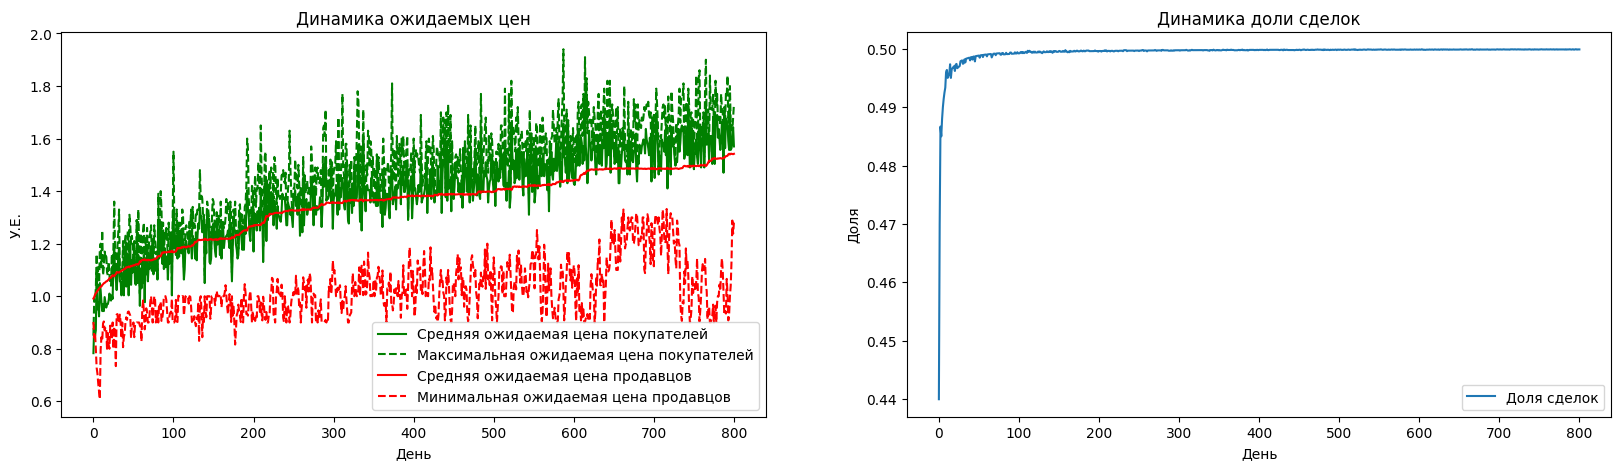

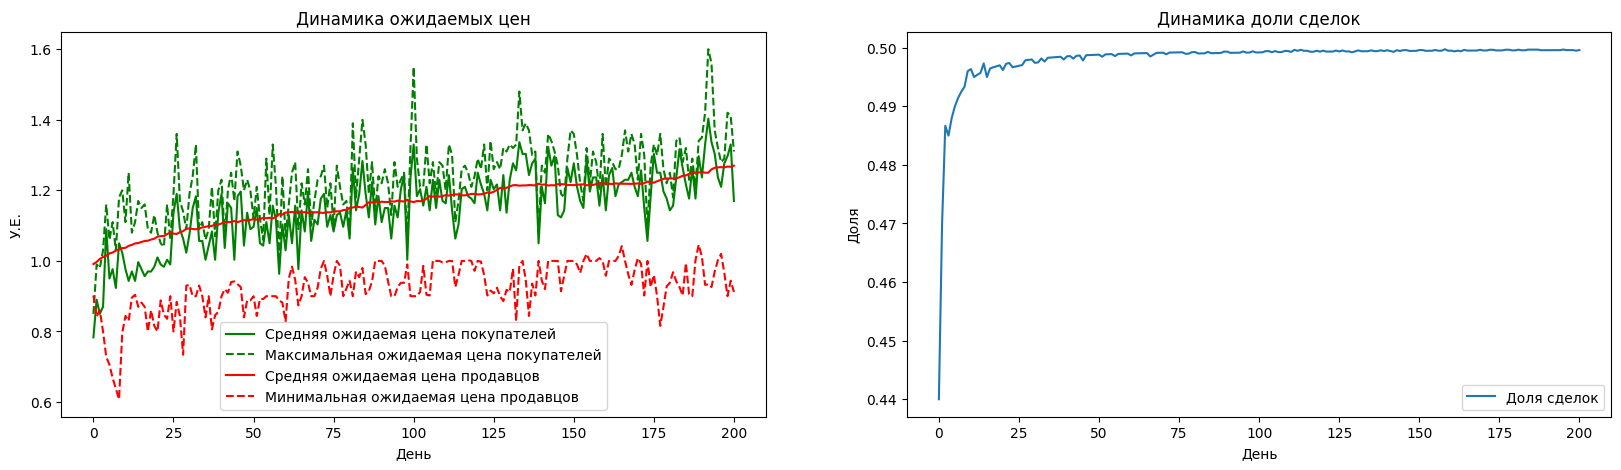

In [ ]:
model.plot_dynamics(0, 800)
model.plot_dynamics(0, 200)

In [ ]:
import random
import matplotlib.pyplot as plt
from tqdm import trange # Модуль для визуализации прогресс-бара при запуске модели
import graphviz # Модуль для визуализации графов

def mean(lst):
    return sum(lst)/len(lst)


class Model_Modef3:
    def __init__(self, num_of_consumers, num_of_sellers, consumer_min, consumer_max, consumer_delta, seller_min, seller_max, seller_delta, subsidy_amount, probability):
        '''
            Конструктор класса.

            num_of_consumers -- количество покупателей
            num_of_sellers -- количество продавцов
            consumer_min -- минимальное возможное значение max_price для покупателей
            consumer_max -- максимально возможное значение max_price для покупателей
            consumer_delta -- шаг изменения expect_price для покупателей
            seller_min -- минимальное возможное значение min_price для продавцов
            seller_max -- максимально возможное значение min_price для продавцов
            seller_delta -- шаг изменения expect_price для продавцов
            subsidy_amount -- размер субсидии
            probability -- вероятность, с которой конкретный продавец (фирма) получает субсидию
            change_factor -- коэффициент изменения seller_delta в случае субсидирования

        '''
        self.num_of_consumers = num_of_consumers
        self.num_of_sellers = num_of_sellers

        # Список всех продавцов модели
        self.consumers = [Consumer(consumer_min, consumer_max, consumer_delta) for _ in range(num_of_consumers)]

        # Список всех покупателей модели
        self.sellers = [Seller(seller_min, seller_max, seller_delta) for _ in range(num_of_sellers)]

        # Список списков. На позиции i находится список текущих значений expect_price для всех покупателей на шаге i.
        self.consumers_expect_price = []

        # Список списков. На позиции i находится список текущих значений expect_price для всех продавцов на шаге i.
        self.sellers_expect_price = []

        # Список результатов сделок. На позиции i находится словарь вида
        # {
        #     'consumer_id' : consumer_id,
        #     'seller_id' : seller_id
        #     'result' : result
        # }
        # где result = 1, если на i шаге была успешная сделка, иначе 0.
        self.deals_results = []

        self.subsidy_amount = subsidy_amount
        self.probability = probability


    def deal(self, consumer_id, seller_id):
        '''
            Моделирование сделки между покупателем с индексом consumer_id и продавцом с индексом seller_id

            consumer_id -- индекс покупателя в массиве self.consumers
            seller_id -- индекс продавца в массиве self.sellers
        '''

        # Определяем по данной вероятности, получил ли на данном шаге продавец субсидию
        chance = random.random()

        # Проверяем, получил ли продавец субсидию, если да, то изменияем seller_delta, если нет, оставляем без изменений
        if chance <= self.probability:
            change_factor = self.subsidy_amount / 200000
            self.sellers[seller_id].delta = self.sellers[seller_id].delta * (1+change_factor)

        # Сохраняем текущие значения expect_price покупателей
        self.consumers_expect_price.append([consumer.expect_price for consumer in self.consumers])

        # Сохраняем текущие значения expect_price продавцов
        self.sellers_expect_price.append([seller.expect_price for seller in self.sellers])

        if self.sellers[seller_id].expect_price <= self.consumers[consumer_id].expect_price:
            # Сделка состоялась

            # Записываем факт состоявшейся сделки
            self.deals_results.append({
                'consumer_id' : consumer_id,
                'seller_id' : seller_id,
                'result' : 1
                })

            # Данный покупатель решает уменьшить у себя expect_price
            self.consumers[consumer_id].decrease_expect_price()

            # Данный продавец решает увеличить у себя expect_price
            self.sellers[seller_id].increase_expect_price()

        else:
            # Сделка не состоялась

            # Записываем факт несостоявшейся сделки
            self.deals_results.append({
                'consumer_id' : consumer_id,
                'seller_id' : seller_id,
                'result' : 0
                })

            # Данный покупатель решает увеличить у себя expect_price
            self.consumers[consumer_id].increase_expect_price()

            # Данный продавец решает уменьшить у себя expect_price
            self.sellers[seller_id].decrease_expect_price()


    def run(self, num_of_steps):
        '''
            Запуск num_of_steps шагов модели
        '''
        for _ in trange(num_of_steps+1): # trange вместо range для визуализации прогресс-бара

            # Выбираем индекс покупателя случайным образом
            consumer_id = random.randrange(0, self.num_of_consumers)

            # Выбираем индекс продавца случайным образом
            seller_id = random.randrange(0, self.num_of_sellers)

            # Моделируем сделку
            self.deal(consumer_id, seller_id)


    def plot_dynamics(self, start, end):
        '''
            Визуализация динамики модели на шагах от start до end включительно
        '''

        # Формируем два графика по горизонтали
        fig = plt.figure(figsize = (20,5))
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)

        # Список точек по оси шагов
        steps_range = list(range(start, end+1))
        ax1.title.set_text("Динамика ожидаемых цен")

        # Среднее значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(mean, self.consumers_expect_price[start : end+1])), color='g', label = "Средняя ожидаемая цена покупателей")

        # Максимальное значение expect_price среди покупателей
        ax1.plot(steps_range, list(map(max, self.consumers_expect_price[start : end+1])), color='g', linestyle='--', label = "Максимальная ожидаемая цена покупателей")

        # Среднее значение expect_price среди продавцов
        ax1.plot(steps_range, list(map(mean, self.sellers_expect_price[start : end+1])), color='r', label = "Средняя ожидаемая цена продавцов")

        # Минимальное значение expect_price среди продавцов
        ax1.plot(steps_range, list(map(min, self.sellers_expect_price[start : end+1])), color='r', linestyle='--', label = "Минимальная ожидаемая цена продавцов")
        ax1.legend()
        ax1.set_xlabel("Шаг")
        ax1.set_ylabel("У.Е.")


        # Находим долю успешных сделок на отрезке от start до end включительно
        deals_sum = [0]
        for i in range(start, end+1):
            deals_sum.append(deals_sum[-1] + self.deals_results[i]['result'])
        deals_fraction = [deals_sum[i] / i for i in range(1, end - start + 2)]
        ax2.title.set_text("Динамика доли сделок")
        ax2.plot(steps_range, deals_fraction, label="Доля сделок")
        ax2.legend()
        ax2.set_xlabel("Шаг")
        ax2.set_ylabel("Доля")

    def plot_supply_and_demand(self, pos_list):
        '''
            Визуализация спроса и предложения в моменты времени, указанные в списке pos_list
        '''

        # Формируем фигуру, состоящую из len(pos) графиков, расположенных горизонтально
        fig, axs = plt.subplots(1, len(pos_list), figsize = (5 * len(pos_list), 5))


        for i in range(len(pos_list)):
            # Для каждого значения из pos рисуем свой график
            axs[i].title.set_text(f"Спрос и предложение в момент {pos_list[i]}")

            # Все значения expect_price для покупателей в момент времени pos[i] сортируем по убыванию.
            # Этот график описывает функцию спроса, т.е. при заданном значении цены мы видим, какое количество покупателей готовы купить товар за данную цену или дороже
            axs[i].plot(list(range(1, self.num_of_consumers+1)), sorted(self.consumers_expect_price[pos_list[i]], reverse=True), color='g', label="Спрос")

            # Все значения expect_price для продавцов в момент времени pos[i] сортируем по возрастанию.
            # Этот график описывает функцию предложения, т.е. при заданном значении цены мы видим, какое количество продавцов готовы продать товар за данную цену или дешевле
            axs[i].plot(list(range(1, self.num_of_sellers+1)), sorted(self.sellers_expect_price[pos_list[i]]), color='r', label="Предложение")

            axs[i].legend()
            axs[i].set_xlabel("Количество")
            axs[i].set_ylabel("У.Е.")

    def plot_graph(self, start, end):
        '''
            Построение и визуализация графа удачных и неудачных сделок
            на отрезке времени от start до end.
        '''
        # Словарь для построения графа сделок.
        # Ключ -- пара (consumer_id, seller_id)
        # Значение -- словарь с ключами 'positive_count' и 'negative_count',
        # в которых будут подсчитано количество удачных и неудачных сделок
        # между consumer_id и seller_id в интервале от start до end
        g_deals = {}

        # Создание всех ключей в g_deals и инициирование нулевыми значениями
        for consumer_id in range(self.num_of_consumers):
            for seller_id in range(self.num_of_sellers):
                g_deals[(consumer_id, seller_id)] = {
                    'positive_count' : 0,
                    'negative_count' : 0,
                }

        # Для всех моментов времени от start до end
        for i in range(start, end+1):


            if self.deals_results[i]['result'] == 0: #Если сделка неудачная
                # то увеличиваем счетчик неудачных сделок для данной пары consumer_id и seller_id
                g_deals[self.deals_results[i]['consumer_id'], self.deals_results[i]['seller_id']]['negative_count'] += 1
            else:
                g_deals[self.deals_results[i]['consumer_id'], self.deals_results[i]['seller_id']]['positive_count'] += 1

        max_value = 0
        for edge, value in g_deals.items():
            max_value = max(max_value, value['negative_count'], value['positive_count'])

        graph = graphviz.Graph()
        for consumer_id in range(self.num_of_consumers):
            graph.node(f"С {consumer_id}", label=str(consumer_id), style='filled', fillcolor='blue')

        for seller_id in range(self.num_of_sellers):
            graph.node(f"S {seller_id}", label=str(seller_id), style='filled', fillcolor='magenta', shape='box')

        def get_penwidth(x):
            return str(10*x // max_value)

        for edge, value in g_deals.items():
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth = get_penwidth(value['negative_count']), color="red")
            graph.edge(f"С {edge[0]}", f"S {edge[1]}", penwidth =  get_penwidth(value['positive_count']), color="green")

        graph.attr(layout="circo")
        return graph


class Consumer:
    def __init__(self, consumer_min, consumer_max, consumer_delta):
        self.max_price = consumer_min + random.random()*(consumer_max - consumer_min)
        self.expect_price = 0
        self.delta = consumer_delta

    def increase_expect_price(self):
        if self.expect_price + self.delta <= self.max_price:
            self.expect_price += self.delta

    def decrease_expect_price(self):
        self.expect_price -= self.delta


class Seller:
    def __init__(self, seller_min, seller_max, seller_delta):
        self.min_price = seller_min + random.random()*(seller_max - seller_min)
        self.expect_price = seller_max
        self.delta = seller_delta

    def increase_expect_price(self):
        self.expect_price += self.delta

    def decrease_expect_price(self):
        if self.expect_price - self.delta >= self.min_price:
            self.expect_price -= self.delta

random.seed(42)
model = Model_Modef3(num_of_consumers=5,
              num_of_sellers=3,
              consumer_min=5,
              consumer_max=7,
              consumer_delta=0.1,
              seller_min=5,
              seller_max=7,
              seller_delta=0.1,
              subsidy_amount=1000,
              probability=0)
model.run(1000)

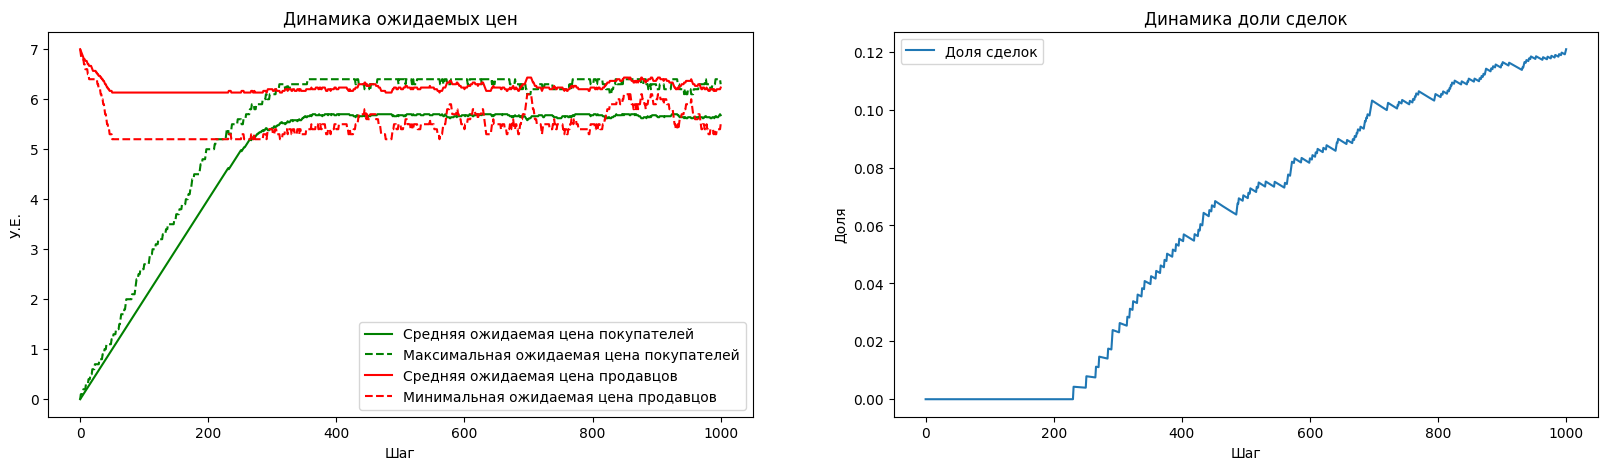

In [ ]:
model.plot_dynamics(0, 1000)